# Multi-objective hyperparameter optimization with Optuna on a synthetic dataset

Welcome! This notebook walks through a minimal example of multi-objective hyperparameter optimization using the [Optuna](https://optuna.readthedocs.io/en/stable/index.html#) automatic hyperparameter optimization framework.  

First, we need something to learn, so we'll generate a small, toy classification problem. We'll define the metrics we care about: the area under the ROC curve, and prediction latency. Then, we'll use the expected hypervolume improvement (EHVI) to find the Pareto frontier of points that maximize these objectives.


While the official [Multi-Objective Optimization with Optuna](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html#sphx-glr-tutorial-20-recipes-002-multi-objective-py) tutorial provides a fantastic example for PyTorch models, here we demonstrate how to use Optuna with scikit-learn and include a comparison with random sampling for hyperparameter optimization.

## Setup

If you already took a look at our tutorial on using [Ax for HPO](https://github.com/fastforwardlabs/multi-objective-hyperparameter-optimization/tree/master/ax-on-synthetic-data) you'll notice Optuna requires only a single import!

In [1]:
import pickle
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Data

Let's generate a classification problem. `sklearn` has a helper for that. The exact parameters aren't too important! In this notebook, we really just want to explore how to use Optuna for multi-objective hyperparameter optimization.

First, we must generate some data, and divide it into a train and development set. We'll train each model on the train set, then 

In [2]:
X, y = make_classification(n_samples=1000, n_features=40, n_informative=20)

We'll make an 80/20 split and use the larger portion for training, and the smaller portion for evaluation. If the algorithm we trained was going to be used, we'd want a third split to report our final metrics on. As is, we might risk overfitting the hyperparameters to the dev set across many trials. To avoid tripling (or more) the run time, we'll skip cross-validation and simply train each algorithm on the train set, and evaluate on dev. We could get a more robust measure of the metrics associated with each hyperparameter configuration by cross-validating each trial.

In [3]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Optimization objectives

Let's say we care about two objectives: the area under the ROC curve (AUC), and latency. AUC captures the quality of a classifier in a threshold-independent way, and is appropriate for the balanced class distribution we have in our toy problem. By optimizing for this, we're finding a good classifier without making a decision about how bad each flavour of misclassification (false positives and false negatives) are, whereas optimizing for a point metric like accuracy directly would be making that call. Latency measures how long a prediction takes. As it turns out, with the scikit-learn multi-layer perceptron model we'll use, not very long. To help smooth out noise in the latency measurement, we'll measure the time required to predict on a batch of a million points.

This will be a small model, and no GPU is used. If we were using a GPU-enabled framework (like PyTorch, TensorFlow, or Jax), we'd need to be a little more careful about how we measure latency (another option is presented in the official Optuna tutorial). Also note that in most applications, we'd probably be more interested in the total response time of a model end point, or the total processing time for a large batch of offline predictions, and it's not necessarily the case that the actual model prediction time is the dominant bottleneck to those things at all!

In [4]:
million_points = np.repeat(X, 1000, axis=0)

In [5]:
def roc(model, X, y):
    return roc_auc_score(y, model.predict(X))

def latency(model, X):
    start = time.time()
    model.predict(X)
    end = time.time()
    return end - start

We define a training routine and compute the objectives. The search space for scikit-learn's `MLPClassifier` is roughly the same as that in [Multi-objective multi-fidelity hyperparameter optimization with application to fairness](https://www.amazon.science/publications/multi-objective-multi-fidelity-hyperparameter-optimization-with-application-to-fairness). Notice that this is a tricky search space! We allow up to three layers in the network, and we only want to sample a layer size for those layers that exist. This means `layer_size` is dependent on `n_layers`. Thankfully, Optuna naturally lends itself to hierarchical search spaces like this because it dynamically constructs the hyperparameter search space for each trial (however, this comes with a drawback as we'll see shortly).  

In [6]:
def train(trial):    
    hidden_layer_sizes = [
        trial.suggest_int(f"layer_{layer+1}_size", 2, 50)
        for layer in range(trial.suggest_int("n_layers", 1, 3))
    ]
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            solver="adam",
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            tol=trial.suggest_float("tol", 1e-5, 1.0, log=True),
            beta_1=trial.suggest_float("beta_1", 0.001, 0.99),
            beta_2=trial.suggest_float("beta_2", 0.001, 0.99),
            learning_rate_init=trial.suggest_float("learning_rate_init", 1e-6, 1e-1, log=True)
        ))
    ])
    
    pipeline.fit(X_train, y_train)
    auc = roc(pipeline, X_dev, y_dev)
    lat = latency(pipeline, million_points)

    return auc, lat

## Experiment setup

We'll run two hyperparameter searches: one using the expected hypervolume improvement (EHVI), and another with pseudo-random sampling for comparison. Optuna initializes the EHVI model for generating new hyperparameter configs with a few random points before performing a fixed number of trials, a process that is performed automatically under-the-hood. 

In [7]:
N_TRIAL = 55  # number of trials to run after initialization

We're just about ready to cleverly optimize our hyperparameters. For this experiment we'll use the MOTPE algorithm detailed in [Multiobjective tree-structured parzen estimator for computationally expensive optimization problems](https://dl.acm.org/doi/10.1145/3377930.3389817). This algorithm uses tree-structured parzen estimators as the surrogate function and EHVI as the acquisition function. We explained how these algorithms work in [Exploring Multi-Objective Hyperparameter Optimization](https://blog.fastforwardlabs.com/2021/07/07/exploring-multi-objective-hyperparameter-optimization.html). In a nutshell, we create a model that takes hyperparameters as inputs and predicts the resultant optimization objectives as outputs. We use this model to find the input hyperparameter combination that will most improve the hypervolume thus expanding the Pareto frontier. Then, we try that hyperparameter config, generating a new data point with which to improve our model, and loop this whole procedure `N_TRIAL` times.

In [8]:
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler, directions=["maximize", "minimize"])
motpe_experiment.optimize(train, n_trials=N_TRIAL)

<ipython-input-8-88b9b9235eb2>:1: ExperimentalWarning: MOTPESampler is experimental (supported from v2.4.0). The interface can change in the future.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2021-06-24 13:33:08,291] A new study created in memory with name: no-name-2683aec9-a927-43aa-a061-b67e320433a8
[I 2021-06-24 13:33:09,437] Trial 0 finished with values: [0.8450000000000001, 0.8262290954589844] and parameters: {'n_layers': 3, 'layer_1_size': 5, 'layer_2_size': 46, 'layer_3_size': 41, 'alpha': 9.16429681464628e-06, 'tol': 4.4073149861688505e-05, 'beta_1': 0.34931254944477413, 'beta_2': 0.9232175410049337, 'learning_rate_init': 0.011713650842477602}. 
[I 2021-06-24 13:33:10,384] Trial 1 finished with values: [0.8999999999999999, 0.8827610015869141] and parameters: {'n_layers': 3, 'layer_1_size': 47, 'layer_2_size': 30, 'layer_3_size': 33, 'alpha': 0.000497863420997646, 'tol': 0.042431076986822885, 'beta_1': 0.40591916231423836, 'beta_2': 0.409687630011716, 'learning_rate_ini

[I 2021-06-24 13:33:24,682] Trial 21 finished with values: [0.8900000000000001, 0.34682798385620117] and parameters: {'n_layers': 1, 'layer_1_size': 7, 'alpha': 0.4220468928331617, 'tol': 0.9205855947906584, 'beta_1': 0.1355045696452603, 'beta_2': 0.12358877798741968, 'learning_rate_init': 0.026215233749186093}. 
[I 2021-06-24 13:33:25,363] Trial 22 finished with values: [0.885, 0.5584681034088135] and parameters: {'n_layers': 2, 'layer_1_size': 2, 'layer_2_size': 37, 'alpha': 0.05927541209993249, 'tol': 0.0029859542692567418, 'beta_1': 0.276718698028048, 'beta_2': 0.6467856636383467, 'learning_rate_init': 0.005313774791799439}. 
[I 2021-06-24 13:33:25,820] Trial 23 finished with values: [0.8949999999999999, 0.39627814292907715] and parameters: {'n_layers': 1, 'layer_1_size': 17, 'alpha': 0.003966062336361071, 'tol': 0.022560292596133607, 'beta_1': 0.14092242274995986, 'beta_2': 0.8719943100057457, 'learning_rate_init': 0.0773444843114371}. 
[I 2021-06-24 13:33:26,580] Trial 24 finishe

[I 2021-06-24 13:33:39,400] Trial 44 finished with values: [0.9000000000000001, 0.35135507583618164] and parameters: {'n_layers': 1, 'layer_1_size': 7, 'alpha': 1.057434176380296e-05, 'tol': 6.707959414130896e-05, 'beta_1': 0.06619735461953394, 'beta_2': 0.07107971291956858, 'learning_rate_init': 0.005405215145553146}. 
[I 2021-06-24 13:33:39,876] Trial 45 finished with values: [0.855, 0.323167085647583] and parameters: {'n_layers': 1, 'layer_1_size': 2, 'alpha': 0.030428082581132613, 'tol': 0.00040121967401255234, 'beta_1': 0.16804638046778253, 'beta_2': 0.17554668696202536, 'learning_rate_init': 0.053521417432980556}. 
[I 2021-06-24 13:33:40,449] Trial 46 finished with values: [0.905, 0.3662989139556885] and parameters: {'n_layers': 1, 'layer_1_size': 10, 'alpha': 0.0007266574593452988, 'tol': 1.0102977147122388e-05, 'beta_1': 0.5207391537224039, 'beta_2': 0.9804189824133966, 'learning_rate_init': 0.02066479427739678}. 
/opt/anaconda3/envs/hpo/lib/python3.9/site-packages/sklearn/neur

As a trade off to the flexibility of a define-by-run hyperparameter space, Optuna’s random search is suboptimal for problems with a fixed, non-dynamic hyperparameter space. Unlike Ax's use of Sobol random, Optuna uses the `numpy` RandomState class to generate independent samples from the parameter space. You can read more about the difference between these types of random sampling in our main blog post (TODO: link again (to the specific section))? 

However, generating an experiment with random sampling is as easy as changing the sampler!

In [9]:
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize"])
random_experiment.optimize(train, n_trials=N_TRIAL, timeout=300)

[I 2021-06-24 13:33:45,156] A new study created in memory with name: no-name-f5ea743f-5351-4c94-bb3b-073cfc71208a
[I 2021-06-24 13:33:45,526] Trial 0 finished with values: [0.855, 0.3397219181060791] and parameters: {'n_layers': 1, 'layer_1_size': 5, 'alpha': 1.6583798916713135e-06, 'tol': 0.04131954057651528, 'beta_1': 0.03944237992080375, 'beta_2': 0.7740661460724664, 'learning_rate_init': 0.04852577351926202}. 
[I 2021-06-24 13:33:46,086] Trial 1 finished with values: [0.8949999999999999, 0.5287368297576904] and parameters: {'n_layers': 1, 'layer_1_size': 42, 'alpha': 0.9963429830202633, 'tol': 0.09246280379558958, 'beta_1': 0.7195088193468046, 'beta_2': 0.29885617879226084, 'learning_rate_init': 0.06860857380535164}. 
[I 2021-06-24 13:33:46,747] Trial 2 finished with values: [0.64, 0.623384952545166] and parameters: {'n_layers': 2, 'layer_1_size': 36, 'layer_2_size': 19, 'alpha': 3.1382750520930222e-06, 'tol': 0.008763082630036568, 'beta_1': 0.7933874414978763, 'beta_2': 0.32699564

[I 2021-06-24 13:34:03,977] Trial 21 finished with values: [0.875, 0.6066792011260986] and parameters: {'n_layers': 2, 'layer_1_size': 50, 'layer_2_size': 3, 'alpha': 0.0007933111984618153, 'tol': 0.04194318984051112, 'beta_1': 0.942039711044863, 'beta_2': 0.8655986481594887, 'learning_rate_init': 0.010487012710084159}. 
/opt/anaconda3/envs/hpo/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2021-06-24 13:34:04,760] Trial 22 finished with values: [0.55, 0.40920495986938477] and parameters: {'n_layers': 1, 'layer_1_size': 15, 'alpha': 0.08577432928050567, 'tol': 0.0005611833437950967, 'beta_1': 0.06544242583279844, 'beta_2': 0.1581465699036227, 'learning_rate_init': 2.9969661296918156e-05}. 
[I 2021-06-24 13:34:05,612] Trial 23 finished with values: [0.5, 0.7926290035247803] and parameters: {'n_layers': 3, 'layer_1_si

[I 2021-06-24 13:34:23,036] Trial 40 finished with values: [0.6000000000000001, 0.5281221866607666] and parameters: {'n_layers': 1, 'layer_1_size': 35, 'alpha': 0.0012641283486926052, 'tol': 0.9282753886154791, 'beta_1': 0.37774095460471235, 'beta_2': 0.6407286452574744, 'learning_rate_init': 1.977844210971094e-06}. 
[I 2021-06-24 13:34:23,420] Trial 41 finished with values: [0.485, 0.35796308517456055] and parameters: {'n_layers': 1, 'layer_1_size': 5, 'alpha': 1.3989383647500107e-05, 'tol': 0.038166776868459595, 'beta_1': 0.5631958946498815, 'beta_2': 0.6935417098351765, 'learning_rate_init': 3.241404263654068e-06}. 
[I 2021-06-24 13:34:24,553] Trial 42 finished with values: [0.8900000000000001, 0.9083409309387207] and parameters: {'n_layers': 3, 'layer_1_size': 27, 'layer_2_size': 26, 'layer_3_size': 34, 'alpha': 1.123847998137992e-05, 'tol': 0.0018205660184223804, 'beta_1': 0.3326677975728737, 'beta_2': 0.1256364390286232, 'learning_rate_init': 0.0017725719114662698}. 
[I 2021-06-2

We provide a helper function that casts the output of the Optuna experiments into an easier-to-read format. 

In [10]:
# Helper function that 
def cast_as_df(optuna_experiment, experiment_type):
    df = (
        optuna_experiment
        .trials_dataframe()
        .rename(columns={"values_0": "auprc", "values_1": "latency"})
        .assign(experiment = experiment_type)
    )
    # the following lines create a column identifing which of the trials resulted in a
    # Best configuration -- a model with these HPs lies along the empirical Pareto frontier
    best_trials = [trial.number for trial in optuna_experiment.best_trials]
    df['best_trial'] = np.where(df.number.isin(best_trials), 1, 0)
    return df

In [11]:
motpe_df = cast_as_df(motpe_experiment, "MOTPE")
random_df = cast_as_df(random_experiment, "Random")

## Visualize Results

We can visually compare the results of MOPTE and random sampling. We want to see a Pareto frontier of points in the lower right corner of the chart - points with the highest accuracy and lowest latency possible.

<ipython-input-12-2d3c23fbdebc>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


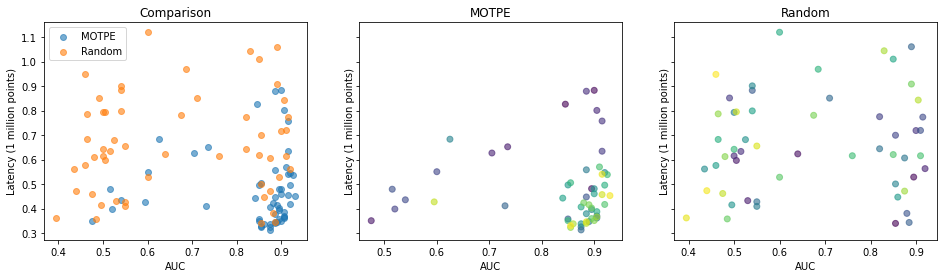

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16,4))
axs[0].scatter(motpe_df.auprc, motpe_df.latency, alpha=0.6, label=motpe_df.experiment[0])
axs[0].scatter(random_df.auprc, random_df.latency, alpha=0.6, label=random_df.experiment[0])
axs[0].legend()
axs[0].set_title("Comparison")

axs[1].scatter(motpe_df.auprc, motpe_df.latency, alpha=0.6, c=motpe_df.number)
axs[1].set_title(motpe_df.experiment[0])

axs[2].scatter(random_df.auprc, random_df.latency, alpha=0.6, c=random_df.number)
axs[2].set_title(random_df.experiment[0])

for ax in axs.flat:
    ax.set(xlabel="AUC", ylabel="Latency (1 million points)")

fig.show()

The leftmost panel shows a comparison of the two experiments, while the middle and right panels show each experiment individually, with their points colored according to the order in which the trials were run. Notice in the MOTPE panel that earlier trials (purple points) are scattered about (reflecting the initialization phase), while later trials (yellow points) have honed in on the Pareto frontier. The same cannot be said for the random experiment, which samples randomly for all trials. 

Because we generated the dataset randomly, and initialized the sampling randomly, it's likely your results differ from ours (we could of course have mitigated this by fixing seeds for the random number generators, but we're very wary of cherry-picking good results, and wanted to encourage some exploration)!  If you've already taken a look at our similar [tutorial using the Ax library](https://github.com/fastforwardlabs/multi-objective-hyperparameter-optimization/tree/master/ax-on-synthetic-data), you might notice that MOTPE and Random are often far more separated than Sobol vs qEVHI in that notebook. While a host of factors contribute to why, we'll mention two explicitly:
1. MOTPE's tree-structured surrogate model (rather than the GP surrogate model used by the Ax library) is likely better suited for hierarchical hyperparameter spaces like that explored here
2. Not all random sampling is equal: Sobol random sampling (in the Ax notebook) provides better coverage than pseudo-random sampling (in this notebook) over fixed hyperparamter spaces.  


With that said, here's an example of one of the more impressive results we obtained, specifically chosen for its spectacular separation of the MOTPE trials and the random trials. Multi-objective Bayesian optimization found a host of models that are faster _and_ more accurate than random search found!
 
![A pretty great result for MOTPE](images/optuna-for-hpo-great.png)

But sometimes, even when MOTPE performs better, it's not always clear why. For example, in the figure below, MOTPE unequivocally better samples the Pareto frontier, but if we look at the order in which those trials were run, these Pareto-esque points were found very early in the optimization (dark purple) and then the algorithm moved _away_ from the Pareto frontier in the remaining trials, as indicated by the yellow points being scattered all over. So we might just have got lucky this time. 

![A strange result for MOTPE](images/optuna-for-hpo-huh.png)

 
